# Import Libraries

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Check if gpu is available


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load and Normalize Dataset


In [ ]:
# Convert to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Model

In [ ]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = FashionNN().to(device)
print(model)


FashionNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


# Loss and Optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training Loop



In [ ]:
epochs = 6
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


for epoch in range(epochs):
   # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_loss = test_loss / len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


Epoch [1/6] - Train Loss: 0.4944, Train Acc: 81.84% | Test Loss: 0.4397, Test Acc: 83.65%
Epoch [2/6] - Train Loss: 0.3704, Train Acc: 86.49% | Test Loss: 0.3791, Test Acc: 86.29%
Epoch [3/6] - Train Loss: 0.3352, Train Acc: 87.69% | Test Loss: 0.3670, Test Acc: 86.54%
Epoch [4/6] - Train Loss: 0.3114, Train Acc: 88.53% | Test Loss: 0.3550, Test Acc: 87.38%
Epoch [5/6] - Train Loss: 0.2948, Train Acc: 88.99% | Test Loss: 0.3543, Test Acc: 86.99%
Epoch [6/6] - Train Loss: 0.2812, Train Acc: 89.44% | Test Loss: 0.3604, Test Acc: 87.14%


# Plot Loss and Accuracy


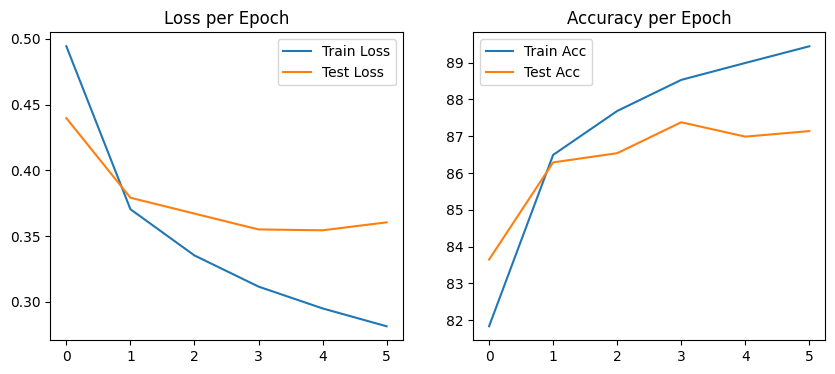

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(); plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.legend(); plt.title('Accuracy per Epoch')
plt.show()

# Confusion Matrix


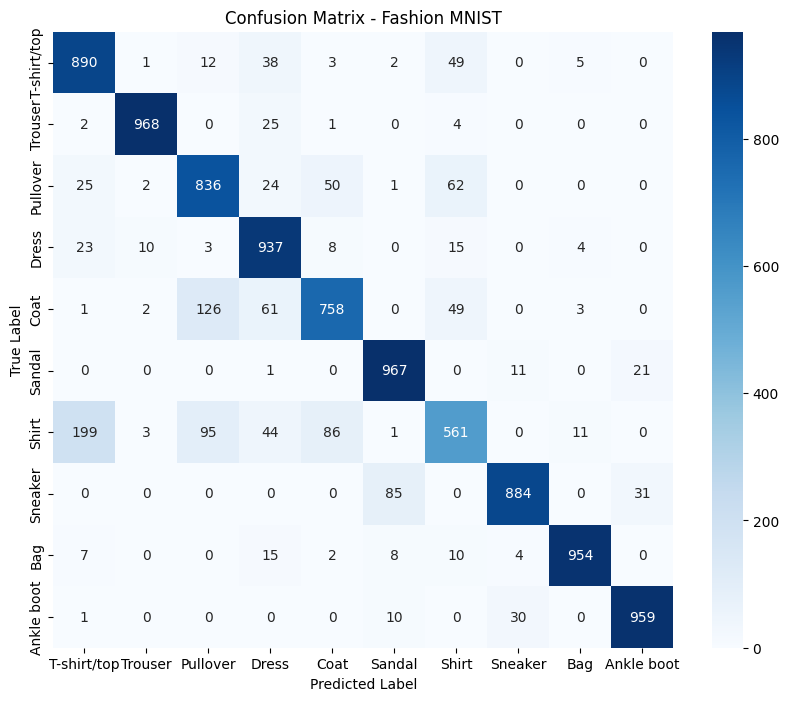

In [ ]:
# Collect all predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Fashion MNIST")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Show Predictions

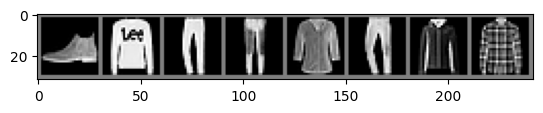

GroundTruth:  Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt
Predicted:    Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(8)))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))

### The fully connected neural network successfully classified the Fashion-MNIST dataset, achieving a final test accuracy of 87.14%, which surpasses the 85% requirement. The training and validation accuracy curves show that the model learned effectively without significant overfitting over 6 epochs. Weight_decay=1e-4 was added in the Adam optimizer as a kind of regularization to help prevent overfitting.